# use vtorch220
Save on GPU, Load on GPU

If both the saving and loading are done on a GPU, you can directly load the state_dict as is, but ensure to move the model to the GPU first before loading the state_dict.

# Save model on GPU
torch.save(model.state_dict(), 'model_gpu.pth')

# Load on GPU
device = torch.device("cuda")<br /> 
model = SimpleModel().to(device)  # Ensure the model is on GPU<br /> 
model.load_state_dict(torch.load('model_gpu.pth'))<br /> 
model.eval()  # Set the model to evaluation mode if needed

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from utils.vqa_dataset_from_pretrained import VQADatasetFromPretrained, load_dataset
from models.vqa_model_from_pretrained import VQAModelFromPretrained

from utils import trainer
import argparse
from utils.optimizer import ControlLR

In [2]:

# load data
#train_data = load_dataset('dataset/vaq2.0.TrainImages.txt')
val_data = load_dataset('dataset/vaq2.0.DevImages.txt')
test_data = load_dataset('dataset/vaq2.0.TestImages.txt')

# create mapping dict
classes = set([sample['answer'] for sample in val_data])
classes_to_idx = {cls_name:idx for idx, cls_name in enumerate(classes)}
idx_to_classes = {idx:cls_name for idx, cls_name in enumerate(classes)}


In [3]:
# create dataloaders
TRAIN_BATCH_SIZE = 128
TEST_BATCH_SIZE = 32
criterion = nn.CrossEntropyLoss()
    
# create model, tokenizer, preprocessor
model = VQAModelFromPretrained(
    visual_pretrained_name='google/vit-base-patch16-224',
    text_pretrained_name='roberta-base',
    n_classes=len(classes)
)
text_tokenizer = model.text_encoder.tokenizer
image_preprocessor = model.visual_encoder.image_preprocessor
#model = model.to(device)

# create datasets
#train_dataset = VQADatasetFromPretrained(train_data, classes_to_idx, image_preprocessor, text_tokenizer)
val_dataset = VQADatasetFromPretrained(val_data, classes_to_idx, image_preprocessor, text_tokenizer)
test_dataset = VQADatasetFromPretrained(test_data, classes_to_idx, image_preprocessor, text_tokenizer)



#train_loader = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

  


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


freezing google/vit-base-patch16-224 parameters


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


freezing roberta-base parameters


In [4]:
#! nvidia-smi

In [5]:
#! kill -9 7540

In [6]:
def test_opt(model_path,device):
    model.load_state_dict(torch.load(model_path))
    #model.load_state_dict(torch.load(model_path)['model_state_dict'])
    val_loss, val_acc = trainer.evaluate(model, val_loader, criterion, device)

    test_loss, test_acc = trainer.evaluate(model, test_loader, criterion, device)
    
    print("Val acc", val_acc)
    print("Test acc", test_acc)

In [17]:
device = 'cuda:0'
print(device)
model_path = './results/basic-StepLR.pt'
test_opt(model_path,device)

cuda:0


61it [01:31,  1.50s/it]
64it [01:35,  1.49s/it]

Val acc 0.7079918032786885
Test acc 0.7007912957467853


In [10]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)#very important position
model_path = './results/basic-ControlLR.pt' 
test_opt(model_path,device) #71.

0it [00:00, ?it/s]We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
61it [01:31,  1.51s/it]
64it [01:35,  1.49s/it]

Val acc 0.7105532786885246
Test acc 0.7012858555885262


In [377]:
'''
device = 'cuda:0'
print(device)
model_path = './save_model/ExponentialLR/basic-ExponentialLR.pt' 
test_opt(model_path,device)
'''

"\ndevice = 'cuda:0'\nprint(device)\nmodel_path = './save_model/ExponentialLR/basic-ExponentialLR.pt' \ntest_opt(model_path,device)\n"

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)#very important position
model_path = './save_model/ExponentialLR/vit-ExponentialLR.pt' 
test_opt(model_path,device)

61it [01:31,  1.50s/it]
64it [01:35,  1.49s/it]

Val acc 0.7064549180327869
Test acc 0.6958456973293768


# Expermental

In [453]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)#very important position
typo ='Expo'
model_path = './save_model/ExponentialLR/vit-ExponentialLR.pt' 
model.load_state_dict(torch.load(model_path))
model.eval()

VQAModelFromPretrained(
  (visual_encoder): VisualEncoder(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            

In [445]:
device = 'cuda:0'
model.to(device)#very important position
typo='Cont'
model_path = './results/basic-ControlLR.pt'
#model_path = './results/basic-StepLR.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()

VQAModelFromPretrained(
  (visual_encoder): VisualEncoder(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            

In [450]:
device = 'cuda:0'
model.to(device)#very important position
typo='Step'
model_path = './results/basic-StepLR.pt'
model.load_state_dict(torch.load(model_path)['model_state_dict'])
model.eval()

VQAModelFromPretrained(
  (visual_encoder): VisualEncoder(
    (model): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTSdpaAttention(
              (attention): ViTSdpaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            

In [9]:
#indx 12 : T - Con, Exp F - Step // Q: Could this be healthy dish ?
#indx 16 : T - Con, Ex F -  S   // Q: Is this a color photograph ?
#indx 50 : T - Con, S F - Ex,   // Q: Is this a potluck ?
indx = 12
image0, question0, label0 = val_dataset.__getone__(indx)
print(question0)
#plt.imshow(image0)
#plt.axis('off')
#plt.title(f"Question: {question0} \n Answer:  {label0} ")
#plt.savefig(f'./png/{indx}.png')
#plt.savefig(f'./png/{indx}_clip.png')

Could this be healthy dish ?


In [441]:
test_loader2 = DataLoader(val_dataset.__getitem__(indx), batch_size=1, shuffle=False)
#device

In [442]:
#image, question, label = next(iter(test_loader2))
image, question, label = iter(test_loader2)
image, question, label = image.to(device), question.to(device), label.to(device)

In [454]:
with torch.no_grad():
  outputs = model(image, question)
  _, predictions = torch.max(outputs.data, 1)
  pred_responses = idx_to_classes[predictions.item()]

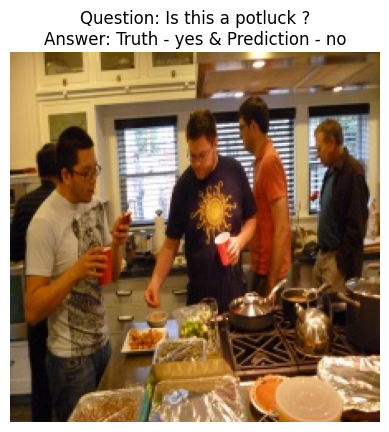

In [455]:

Question = question0
Response =  label0
plt.imshow(image0)

with torch.no_grad():
  outputs = model(image, question)
  _, predictions = torch.max(outputs.data, 1)
  pred_responses = idx_to_classes[predictions.item()]
  
plt.title(f"Question: {Question}\nAnswer: Truth - {Response} & Prediction - {pred_responses}")
plt.axis('off')
plt.savefig(f'./png/{indx}-{typo}_vit.png')